In [1]:
%ls

sample_data/


In [0]:
from google.colab import drive 
drive.mount("bdrive")

In [0]:
cd bdrive/My\ Drive/app/Hair-segmentation/

In [0]:
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras import Input
from keras.applications.mobilenet import DepthwiseConv2D, relu6
from keras.layers import BatchNormalization, Activation, Conv2D, concatenate, Conv2DTranspose
from layers import BilinearUpSampling2D
from keras.engine import Model

from keras import backend as K
from keras import callbacks, optimizers
from keras.models import load_model
from keras.utils import CustomObjectScope

import warnings
warnings.filterwarnings("ignore")

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels

Using TensorFlow backend.


## Data

In [0]:
def normalize(image, mean=None, std=None):
  if mean is None:
    mean = [[[29.24429131, 29.24429131, 29.24429131]]]
  if std is None:
    std = [[[69.8833313, 63.37436676, 61.38568878]]]
  x = (image - np.array(mean)) / (np.array(std) + 1e-7)
  return x

def create_datagen(images, labels, img_generator, lbl_generator, seed):
  img_iter = img_generator.flow(images, seed=seed)
  lbl_iter = lbl_generator.flow(labels, seed=seed)
  
  def datagen():
    while True:
      img = img_iter.next()
      lbl = lbl_iter.next()
      yield img, lbl
      
  return datagen

def load_data(img_file, mask_file):
  seed = 1
  images = np.load(img_file)
  labels = np.load(mask_file)
  
  x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=seed)
  
  train_img_gen = ImageDataGenerator(featurewise_center = True,
                                     featurewise_std_normalization=True,
                                     rotation_range= 20,
                                     shear_range= 0.2, 
                                     zoom_range= 0.2,
                                     horizontal_flip = True)
  train_img_gen.fit(images)
  
  train_lab_gen = ImageDataGenerator(rescale =1./255,
                                     rotation_range=20,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip = True)
  
  train_gen = create_datagen(x_train, y_train, train_img_gen, train_lab_gen, seed)
  
  valid_img_gen = ImageDataGenerator(featurewise_center = True,
                                     featurewise_std_normalization = True,
                                     horizontal_flip = True)
  
  valid_img_gen.fit(images)
  
  valid_lab_gen = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip = True)
  
  valid_gen = create_datagen(x_val, y_val, valid_img_gen, valid_lab_gen, seed)
  
  return train_gen, valid_gen, images.shape[1:3]

# DL Model

In [0]:
def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1), block_id=1):
  channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
  filters = int(filters * alpha)
  
  x = Conv2D(filters, kernel, padding='same', use_bias=False, strides=strides, name='conv_%d' % block_id)(inputs)
  x = BatchNormalization(axis=channel_axis, name='conv_%d_bn' % block_id)(x)
  return Activation(relu6, name='conv_%d_relu' % block_id)(x)

def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha, depth_multiplier=1, strides=(1, 1), block_id=1):
  channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
  pointwise_conv_filters = int(pointwise_conv_filters * alpha)
  
  x = DepthwiseConv2D((3, 3),
                      padding='same',
                      depth_multiplier=depth_multiplier,
                      strides=strides,
                      use_bias=False,
                      name='conv_dw_%d' % block_id)(inputs)
  
  x = BatchNormalization(axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
  x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)
  
  x = Conv2D(pointwise_conv_filters, (1, 1), padding='same', use_bias=False, strides=(1, 1), name='conv_pw_%d' % block_id)(x)
  x = BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
  return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)

def MobileUNet(input_shape=None, alpha=1.0, alpha_up=1.0, depth_multiplier=1, dropout=1e-3, input_tensor=None):
  if input_tensor is None:
    img_input = Input(shape=input_shape)
  else:
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor
      
  b00 = _conv_block(img_input, 32, alpha, strides=(2, 2), block_id=0)
  
  b01 = _depthwise_conv_block(b00, 64, alpha, depth_multiplier, block_id=1)
  b02 = _depthwise_conv_block(b01, 128, alpha, depth_multiplier, block_id=2, strides=(2, 2))
  b03 = _depthwise_conv_block(b02, 128, alpha, depth_multiplier, block_id=3)
  b04 = _depthwise_conv_block(b03, 256, alpha, depth_multiplier, block_id=4, strides=(2, 2))
  b05 = _depthwise_conv_block(b04, 256, alpha, depth_multiplier, block_id=5)
  b06 = _depthwise_conv_block(b05, 512, alpha, depth_multiplier, block_id=6, strides=(2, 2))
  b07 = _depthwise_conv_block(b06, 512, alpha, depth_multiplier, block_id=7)
  b08 = _depthwise_conv_block(b07, 512, alpha, depth_multiplier, block_id=8)
  b09 = _depthwise_conv_block(b08, 512, alpha, depth_multiplier, block_id=9)
  b10 = _depthwise_conv_block(b09, 512, alpha, depth_multiplier, block_id=10)
  b11 = _depthwise_conv_block(b10, 512, alpha, depth_multiplier, block_id=11)
  b12 = _depthwise_conv_block(b11, 1024, alpha, depth_multiplier, block_id=12, strides=(2, 2))
  b13 = _depthwise_conv_block(b12, 1024, alpha, depth_multiplier, block_id=13)
  
  filters = int(512 * alpha)
  up1 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b13), b11], axis=3)
  b14 = _depthwise_conv_block(up1, filters, alpha_up, depth_multiplier, block_id=14)
  
  filters = int(256 * alpha)
  up2 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b14), b05], axis=3)
  b15 = _depthwise_conv_block(up2, filters, alpha_up, depth_multiplier, block_id=15)
  
  
  filters = int(128 * alpha)
  up3 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b15), b03], axis=3)
  b16 = _depthwise_conv_block(up3, filters, alpha_up, depth_multiplier, block_id=16)
  
  filters = int(64 * alpha)
  up4 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b16), b01], axis=3)
  b17 = _depthwise_conv_block(up4, filters, alpha_up, depth_multiplier, block_id=17)
  
  filters = int(32 * alpha)
  up5 = concatenate([b17, b00], axis=3)
  b18 = _conv_block(up5, filters, alpha_up, block_id=18)
  
  x = Conv2D(3, (1, 1), kernel_initializer='he_normal', activation='linear')(b18)
  x = BilinearUpSampling2D(size=(2, 2))(x)
  x = Activation('sigmoid')(x)
  
  model = Model(img_input, x)
  return model

## Training

### Loss

In [0]:
def DICE_coef_loss(pred, truth, smooth = 1e-5):
  pred_f = K.flatten(pred)
  truth_f = K.flatten(truth)
  intersection = K.sum(truth_f * pred_f)
  
  return 1-((2. * intersection + smooth) / (K.sum(truth_f) + K.sum(pred_f) + smooth))

### Scheduler

In [0]:
def create_lr_schedule(epochs):
  return lambda epoch: _lr_schedule(epoch, epochs)

def _lr_schedule(epoch, epochs):
  if epoch > 0.9 * epochs: lr = 0.0001
  elif epoch > 0.75 * epochs: lr = 0.001
  elif epoch > 0.5 * epochs: lr = 0.01
  else: lr = 0.1
    
  return lr

### Train

In [0]:
def train(train_gen, val_gen, model, epochs=250, batch_size=16):
  
  model.compile(optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                loss = DICE_coef_loss)
  
  scheduler = callbacks.LearningRateScheduler(create_lr_schedule(epochs))
  checkpoint = callbacks.ModelCheckpoint(filepath="unet-keras-model-weights2.hd5",
                                         save_weights_only= True,
                                         save_best_only = True)
  
  model.fit_generator(generator=train_gen(),
                      steps_per_epoch = 2341 // batch_size,
                      epochs = epochs,
                      validation_data = val_gen(),
                      validation_steps = 586 // batch_size,
                      callbacks=[scheduler, checkpoint])
  
  model.save("unet-keras-model2.h5")

In [0]:
train_gen, val_gen, img_shape = load_data("data/LFW-keras/images-192.npy", "data/LFW-keras/masks-192.npy")
model =  MobileUNet(input_shape=(img_shape[0], img_shape[1], 3), alpha=1, alpha_up=0.25)

In [0]:

train(train_gen, val_gen, model)

In [0]:
model.save("unet-keras-model2.h5")

## Inference

In [0]:
def custom_objects():
  return {'relu6': relu6,
          'DepthwiseConv2D': DepthwiseConv2D,
          'BilinearUpSampling2D': BilinearUpSampling2D,
          'dice_coef_loss': DICE_coef_loss
         }

def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

In [0]:
SAVED_MODEL = 'unet-keras-model2.h5'
SAVED_WEIGHTS = 'unet-keras-model-weights2.hd5'

with CustomObjectScope(custom_objects()):
  model = load_model(SAVED_MODEL)
  model.load_weights(SAVED_WEIGHTS)

images = np.load('data/LFW-keras/images-192.npy')
masks = np.load('data/LFW-keras/masks-192.npy')


id_img = 68

original = images[id_img]
image = images[id_img].reshape(1, 192, 192, 3).astype(float)
label = masks[id_img]

prob_pred = model.predict(normalize(image)).reshape(192, 192, 3)
pred = np.uint8((prob_pred.round())*255)

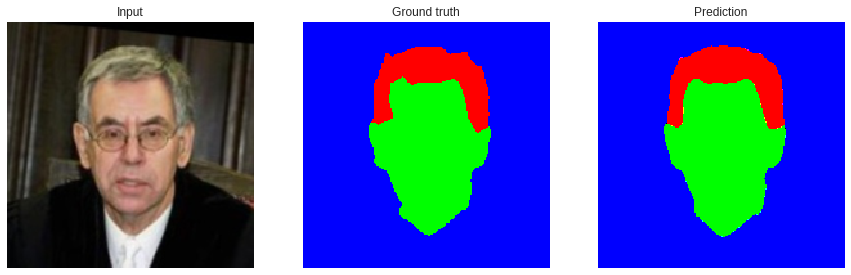

In [21]:
plot_imgs([original, label, pred], ["Input", "Ground truth", "Prediction"], (15, 15))

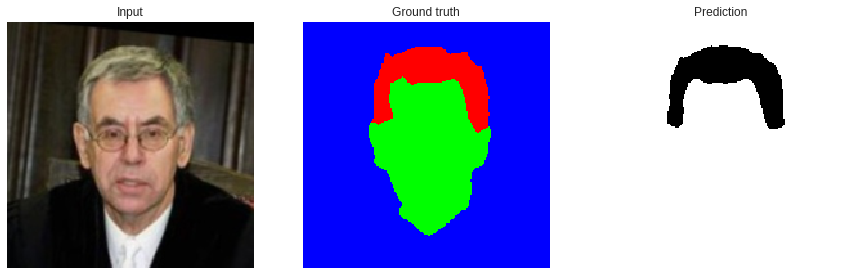

In [22]:
plot_imgs([original, label, pred[:,:,0]], ["Input", "Ground truth", "Prediction"], (15, 15))

# Fully connected CRF 

In [0]:
def CRF(orginal, prediction, c, iteractions=5):
  prediction = prediction[:,:,c] #+ (prediction[:,:,0]<<8) + (prediction[:,:,2]<<16)
  
  colors, labels = np.unique(prediction, return_inverse=True)
  
  colorize = np.empty((len(colors), 3), np.uint8)
  
  colorize[:,0] = (colors & 0x0000FF)
  colorize[:,1] = (colors & 0x00FF00) >> 8
  colorize[:,2] = (colors & 0xFF0000) >> 16
  
  n_labels = len(set(labels.flat))
  
  d = dcrf.DenseCRF2D(original.shape[1], original[3].shape[0], n_labels)
  U = unary_from_labels(labels, n_labels, gt_prob=0.9, zero_unsure=False)
  d.setUnaryEnergy(U)
  d.addPairwiseGaussian(sxy=(3, 3), compat=4, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
  d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
  
  Q = d.inference(iteractions)
  
  output = np.argmax(Q, axis=0)
  output = colorize[output,:]
  output = output.reshape(192, 192, 3)
  return output 

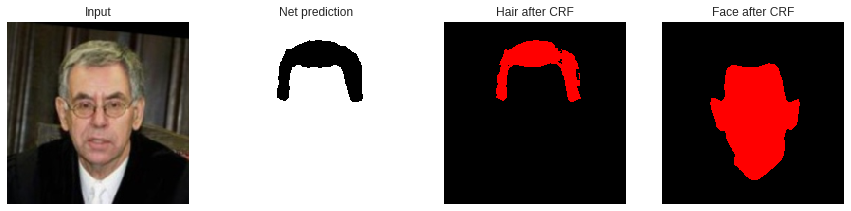

In [24]:
crf_hair_image = CRF(original, pred, 0, 1)
crf_face_image = CRF(original, pred, 1, 1)

plot_imgs([original, pred[:,:,0], crf_hair_image, crf_face_image], ["Input",  "Net prediction", "Hair after CRF", "Face after CRF" ], (15, 15))

# Image matting

## Generate trimaps

In [0]:
from skimage import data
from scipy import ndimage
import cv2, os
import numpy as np

In [0]:
def get_trimap(img, size, number):

    pixels    = 2*size + 1;                                
    kernel    = np.ones((pixels,pixels),np.uint8)
    dilation  = cv2.dilate(img, kernel, iterations = 1) 

    dilation  = np.where(dilation == 255, 127, dilation) 		
    remake    = np.where(dilation != 127, 0, dilation)		
    remake    = np.where(img > 127, 200, dilation)			

    remake    = np.where(remake < 127, 0, remake)		
    remake    = np.where(remake > 200, 0, remake)			
    remake    = np.where(remake == 200, 255, remake)	
    
    return remake

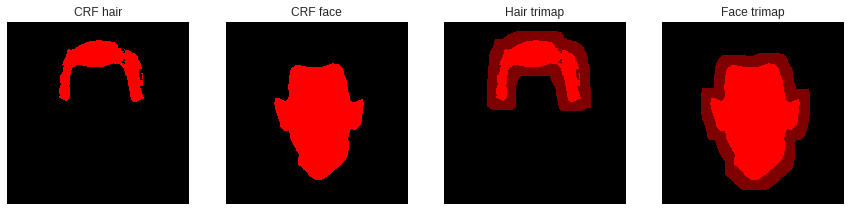

In [39]:
size = 10
number = 1

hair_trimap = get_trimap(crf_hair_image, size, number)
face_trimap = get_trimap(crf_face_image, size, number)

plot_imgs([crf_hair_image, crf_face_image, hair_trimap, face_trimap], ["CRF hair",  "CRF face", "Hair trimap", "Face trimap" ], (15, 15))